# IAQ and Fitbit-Measured Sleep Exploration
Arguably the main attraction (for me at least), we explore the effect of IAQ parameters on Fitbit-measured sleep parameters.

## Percent Change in Nightly Pollutants and Fitbit-Measured SE/REM:NREM

At the writing of this notebook, the beacons have not been post-calibrated. Therefore the pollutant metric to consider is the percent change or some differencing approach because the changes are correct, while the values might not be.

In [156]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import statsmodels.api as sm

## Data Import
For this analysis we need both daily Fitbit sleep summary and the sleep stages summary files

### Fitbit Sleep Summary

In [157]:
sleep = pd.read_csv("../data/processed/bpeace2-fitbit-sleep-daily.csv",
                    parse_dates=['date','startTime','endTime'],infer_datetime_format=True)
end_dates = []
for d in sleep['endTime']:
    end_dates.append(d.date())
sleep['endDate'] = end_dates
sleep.head()

,date,dateOfSleep,duration,efficiency,endTime,infoCode,isMainSleep,logId,minutesAfterWakeup,minutesAsleep,minutesAwake,minutesToFallAsleep,startTime,timeInBed,beiwe,endDate
0,2020-05-01,2020-05-01,38400000,92,2020-05-01 12:12:30,0,True,26980914882,0,567,73,0,2020-05-01 01:32:30,640,15tejjtw,2020-05-01
1,2020-05-02,2020-05-02,39060000,91,2020-05-02 13:13:00,0,True,26996086598,0,557,94,0,2020-05-02 02:21:30,651,15tejjtw,2020-05-02
2,2020-05-03,2020-05-03,21660000,88,2020-05-03 08:01:00,0,True,27009771663,1,301,60,0,2020-05-03 01:59:30,361,15tejjtw,2020-05-03
3,2020-05-04,2020-05-04,36480000,89,2020-05-04 14:13:30,0,True,27022238683,0,515,93,0,2020-05-04 04:05:00,608,15tejjtw,2020-05-04
4,2020-05-06,2020-05-06,30420000,87,2020-05-06 10:24:00,0,True,27052041978,0,433,74,0,2020-05-06 01:56:30,507,15tejjtw,2020-05-06


### Fitbit Sleep Stage Summary

In [158]:
stages = pd.read_csv("../data/processed/bpeace2-fitbit-sleep-stages-summary.csv",
                     index_col=0,parse_dates=['startDate','endDate'],infer_datetime_format=True)
end_dates = []
for d in stages['endDate']:
    end_dates.append(d.date())
stages['endDate'] = end_dates
stages.head()

,startDate,endDate,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,beiwe
0,2020-05-01,2020-05-01,5,119,43,313,18,135,53,73,15tejjtw
1,2020-05-02,2020-05-02,4,115,46,336,12,106,47,94,15tejjtw
2,2020-05-03,2020-05-03,4,90,22,157,5,54,20,60,15tejjtw
3,2020-05-04,2020-05-04,5,104,40,323,8,88,37,93,15tejjtw
4,2020-05-06,2020-05-06,4,101,30,211,19,121,34,74,15tejjtw


### Beacon IAQ
And lastly the IAQ measurements courtesy of the beacons

In [159]:
beacon = pd.read_csv('../data/processed/bpeace2-beacon.csv',index_col=0,parse_dates=True)
beacon.head()

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,z,Beacon,Beiwe,Fitbit,REDCap
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4


## Pre-processing
The new Fitbit files nicely summarize the sleep data for us and also give the start and stop times for the sleep events (SO convenient!). The only thing we have to pre-process is the beacon data by removing all data for each participant that is not in their daily sleep windows. 

However, since the stages summary and sleep summary come from different files, I need to make sure that they have the same number of nights per participant.

In [160]:
for pt in sleep['beiwe'].unique():
    sleep_pt = sleep[sleep['beiwe'] == pt]
    stage_pt = stages[stages['beiwe'] == pt]
    if len(sleep_pt) != len(stage_pt):
        print('{pt}: different lengths')

Nothing was printed so they seem to be the same length!

### IAQ and Sleep Summary per Night
Now we can loop through the start and stop times for sleep, get the IAQ data, summarize it, and then combine the three dataframes into one. Might as well save this datafile too for future use.

In [161]:
iaq_sleep = pd.DataFrame()
for pt in sleep['beiwe'].unique():
    # getting data per participant
    beacon_pt = beacon[beacon['Beiwe'] == pt]
    sleep_pt = sleep[sleep['beiwe'] == pt]
    stages_pt = stages[stages['beiwe'] == pt]
    # summarizing beacon data per night
    beacon_summary = pd.DataFrame()
    for start_time, end_time in zip(sleep_pt['startTime'],sleep_pt['endTime']):
        beacon_pt_night = beacon_pt[start_time:end_time]
        if len(beacon_pt_night) > 0:
            summary_dict = {'start_date':[start_time.date()],'end_date':[end_time.date()]}
            for variable in ['CO2','PM_C_2p5','CO','NO2','TVOC']:
                summary_dict[f'{variable}_min'] = np.nanmin(beacon_pt_night[variable])
                summary_dict[f'{variable}_max'] = np.nanmax(beacon_pt_night[variable])
                summary_dict[f'{variable}_mean'] = np.nanmean(beacon_pt_night[variable])
                summary_dict[f'{variable}_med'] = np.nanmedian(beacon_pt_night[variable])
                summary_dict[f'{variable}_25'] = np.percentile(beacon_pt_night[variable],25)
                summary_dict[f'{variable}_75'] = np.percentile(beacon_pt_night[variable],75)
                summary_dict[f'{variable}_std'] = np.nanstd(beacon_pt_night[variable])
                summary_dict[f'{variable}_initial'] = beacon_pt_night[variable][0]
                summary_dict[f'{variable}_final'] = beacon_pt_night[variable][-1]
                
            beacon_summary = beacon_summary.append(pd.DataFrame(summary_dict))
    if len(beacon_summary) > 0:
        temp = pd.merge(left=beacon_summary,right=sleep_pt,left_on='end_date',right_on='endDate',how='inner')
        iaq_sleep_pt = pd.merge(left=temp,right=stages_pt,left_on='end_date',right_on='endDate',how='inner')
        iaq_sleep = iaq_sleep.append(iaq_sleep_pt)
        
# adding in REM:nREM
iaq_sleep['rem2nrem'] = iaq_sleep['rem_minutes'] / (iaq_sleep['light_minutes'] + iaq_sleep['deep_minutes'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: All-NaN axis encountered
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: All-NaN axis encountered
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


This dataframe contains a lot of important data, so we might as well save it to the processed folder.

In [162]:
iaq_sleep.to_csv('../data/processed/bpeace2-fitbit-beacon-sleep-iaq.csv')

## Visualizing
With these data summamrized, we can start to look at the relationship between sleep and IAQ.

We can start simple by looking at one variable and it's effect on sleep efficiency. Then the code we develop here can be adapted for analysis on other variables. 

### CO2 and Sleep Efficiency
We can look at a scatterplot comparing multiple summary statistics of CO2 with sleep efficiency.

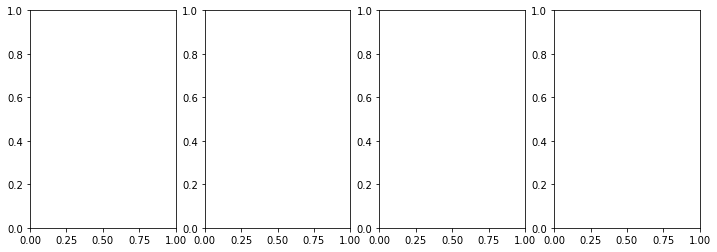

In [259]:
fig, ax = plt.subplots(1,4,figsize=(12,4))
co2 = iaq_sleep
co2['diff'] = co2['CO2_max'] - co2['CO2_min']
co2['delta'] = co2['CO2_final'] - co2['CO2_initial']
for stat in ['diff','delta','CO2_med','CO2_std']:
    pass

# Old

### Percent Change Histogram
The first thing to do is create a histogram of the percentage change values for each pollutant.

In [221]:
iaq_sleep.columns

Index(['start_date', 'end_date', 'CO2_min', 'CO2_max', 'CO2_mean', 'CO2_med',
       'CO2_25', 'CO2_75', 'CO2_std', 'CO2_initial', 'CO2_final',
       'PM_C_2p5_min', 'PM_C_2p5_max', 'PM_C_2p5_mean', 'PM_C_2p5_med',
       'PM_C_2p5_25', 'PM_C_2p5_75', 'PM_C_2p5_std', 'PM_C_2p5_initial',
       'PM_C_2p5_final', 'CO_min', 'CO_max', 'CO_mean', 'CO_med', 'CO_25',
       'CO_75', 'CO_std', 'CO_initial', 'CO_final', 'NO2_min', 'NO2_max',
       'NO2_mean', 'NO2_med', 'NO2_25', 'NO2_75', 'NO2_std', 'NO2_initial',
       'NO2_final', 'TVOC_min', 'TVOC_max', 'TVOC_mean', 'TVOC_med', 'TVOC_25',
       'TVOC_75', 'TVOC_std', 'TVOC_initial', 'TVOC_final', 'date',
       'dateOfSleep', 'duration', 'efficiency', 'endTime', 'infoCode',
       'isMainSleep', 'logId', 'minutesAfterWakeup', 'minutesAsleep',
       'minutesAwake', 'minutesToFallAsleep', 'startTime', 'timeInBed',
       'beiwe_x', 'endDate_x', 'startDate', 'endDate_y', 'deep_count',
       'deep_minutes', 'light_count', 'light_minutes',

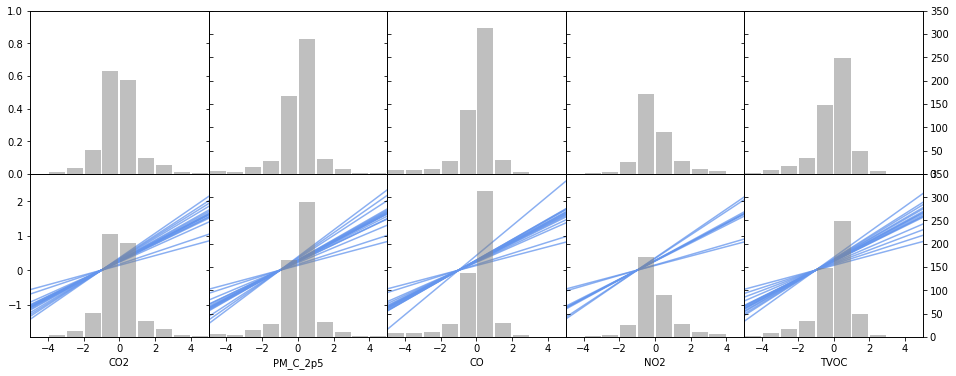

In [258]:
fig, axes = plt.subplots(2,5,figsize=(16,6),sharex='col',sharey='row')
r = 0
for sleep_metric in ['efficiency','rem2nrem']:
    c = 0
    for variable in ['CO2','PM_C_2p5','CO','NO2','TVOC']:
        ax = axes[r,c]
        temp = iaq_sleep
        diff = (iaq_sleep[f'{variable}_final']-iaq_sleep[f'{variable}_initial']) 
        temp['z'] = (diff - np.nanmean(diff)) / np.nanstd(diff)
        temp[abs(temp['z']) > 5] = np.nan
        for pt in temp['beiwe_x'].unique():
            temp_pt = temp[temp['beiwe_x'] == pt]
            temp_pt = temp_pt.dropna(subset=['z',sleep_metric])
            x = temp_pt['z'].values
            y = temp_pt[sleep_metric].values
            if len(x) > 1:
                # OLS - intercept at origin
                pt_model = sm.OLS(y,sm.add_constant(x)).fit()

                if pt_model.params[0]*-5 < -4:
                    pass
                else:
                    ax.plot([-5,5],[pt_model.params[0]+pt_model.params[0]*-5,pt_model.params[0]+pt_model.params[0]*5],color='cornflowerblue',alpha=0.75)
        
        ax2 = ax.twinx()
        ax2.hist(temp['z'],color='gray',bins=np.arange(-5,6,1),rwidth=0.9,alpha=0.5,zorder=1)
        ax2.set_xlim([-5,5])
        ax2.set_ylim([0,350])
        if r == 1:
            ax.set_xlabel(f'{variable}')
        if c == 4:
            pass
        else:
            ax2.set_yticklabels([''])
        c += 1
        
    r += 1
    
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()
plt.close()